# **Setup Code**

In [3]:
# Installing required packages
!pip install lovely-numpy
stable = True # Set to True for latest pip version or False for main branch in GitHub
!pip install {"tsai -U" if stable else "git+https://github.com/timeseriesAI/tsai.git"} >> /dev/null

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 6.7 MB/s 


In [4]:
# connecting to drive and importing packages
from google.colab import drive
from tqdm import tqdm
import os
import pandas as pd
import numpy as np
import math
import datetime
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from dateutil import rrule
from datetime import datetime, timedelta

data_path = "/content/gdrive/MyDrive/WeatherData"


drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


## Load Stations

*   Apex Mountain Lodge is not used due to the file being mostly empty
*   Beaverdell, OkanaganFAlls2S and OkanaganMission do not record temperature
*   HedleyNPMine is mostly empty
*   SummerlandCS does not record precipitation


In [5]:
# setup data-import
stations = pd.read_csv(os.path.join(data_path, 'stations.csv'))
stations

StationID  time-start    time-end             file-name  longitudeX  \
0        1053  1970-01-01  2011-12-31           PentictionA -119.602222   
1        1026  1991-01-01  2003-12-31              Naramata -119.571000   
2        1062  1970-01-01  1994-12-31         SummerlandCDA -119.650000   
3        1036  1983-01-01  1990-12-31      OKFallsMcleanCrk -119.533333   
4         982  1971-01-01  1975-12-31               Arawana -119.566667   
5       26994  1997-01-01  2007-12-31  PeachlandGreataRanch -119.741167   
6        6836  1992-01-01  1994-12-31               Oliver3 -119.550000   
7        1039  1973-01-01  2006-12-31             OliverSTP -119.544694   
8        1010  1980-01-01  1999-12-31             Keremeos2 -119.821333   
9        1037  1970-01-01  1994-12-31                Oliver -119.564167   
10       1037  1996-01-01  2007-12-31               Oliver1 -119.564167   
11       1009  1970-01-01  1979-12-31              Keremeos -119.816667   
12        990  1980-01-01  1981-12-31    CawstonSimilkameen -119.766667   
13       1047  1974-01-01  1981-12-31             Peachland -119.714458   
14      26993  1998-01-01  2002-12-31     KelownaCedarcreek -119.541500   
15      26993  2004-01-01  2007-12-31    KelownaCedarcreek1 -119.541500   
16       1046  1991-01-01  2011-12-31          PeachlandNew -119.716667   

    latitudeY  elevation  
0   49.463056      344.4  
1   49.550667      411.0  
2   49.566667      454.2  
3   49.350000      455.1  
4   49.583333      518.2  
5   49.700333      398.0  
6   49.183333      280.0  
7   49.179028      297.2  
8   49.210333      434.9  
9   49.165833      315.2  
10  49.165833      315.2  
11  49.200000      415.0  
12  49.183333      398.0  
13  49.782781      351.0  
14  49.789333      375.0  
15  49.789333      375.0  
16  49.783333      345.0

# Download and Save Weather Data to .csv
(Only needs to be done once per computer)

In [7]:
# import weather data from Envrionment Canada (modified template by https://github.com/csianglim/weather-gc-ca-python/ published with MIT license)
def save_weather_station(station_id, start_date, end_date):
  os.chdir(data_path)
  frames = []
  for dt in rrule.rrule(rrule.YEARLY, dtstart=start_date, until=end_date):
      #print(dt)
      query_string = f"https://climate.weather.gc.ca/climate_data/bulk_data_e.html?format=csv&stationID={station_id}&Year={dt.year}&Month={dt.month}&Day=14&timeframe=2"
      #print(query_string)
      frames.append(pd.read_csv(query_string, sep=',', engine='python'))
  return pd.concat(frames)

In [8]:
stations["time-start"], stations["time-end"] = pd.to_datetime(stations["time-start"]), pd.to_datetime(stations["time-end"])
#stations.head()

In [9]:
stations_list = []
for i in tqdm(range(stations.shape[0])):
  stations_list.append(save_weather_station(stations.iloc[i, 0], start_date=stations.iloc[i,1], end_date=stations.iloc[i,2]))

100%|██████████| 17/17 [01:08<00:00,  4.01s/it]


In [10]:
for i in range(len(stations_list)):
  stations_list[i].drop(columns=["Station Name","Climate ID","Data Quality","Year","Max Temp Flag","Min Temp Flag","Heat Deg Days (°C)","Cool Deg Days (°C)","Mean Temp Flag","Heat Deg Days Flag","Cool Deg Days Flag","Total Rain Flag","Total Snow Flag","Total Precip (mm)","Total Precip Flag","Snow on Grnd (cm)","Snow on Grnd Flag","Dir of Max Gust (10s deg)","Dir of Max Gust Flag","Spd of Max Gust (km/h)","Spd of Max Gust Flag"], inplace=True)
  pd.to_datetime(stations_list[i]['Date/Time'])
  stations_list[i]["Longitude (x)"] = stations["longitudeX"].iloc[i]
  stations_list[i]["Latitude (y)"] = stations["latitudeY"].iloc[i]
  stations_list[i]["Elevation (m)"] = stations["elevation"].iloc[i]

  #pd.to_numeric(columns=["Longitude (x)","Latitude (y)","Month","Day","Max Temp (°C)","Min Temp (°C)","Mean Temp (°C)","Heat Deg Days (°C)","Cool Deg Days (°C)","Total Rain (mm)","Total Snow (cm)"])

In [11]:
stations_list[0].head()

Longitude (x)  Latitude (y)   Date/Time  Month  Day  Max Temp (°C)  \
0    -119.602222     49.463056  1970-01-01      1    1           -0.6   
1    -119.602222     49.463056  1970-01-02      1    2           -1.1   
2    -119.602222     49.463056  1970-01-03      1    3           -0.6   
3    -119.602222     49.463056  1970-01-04      1    4           -1.1   
4    -119.602222     49.463056  1970-01-05      1    5           -3.9   

   Min Temp (°C)  Mean Temp (°C)  Total Rain (mm)  Total Snow (cm)  \
0           -5.6            -3.1              0.0              0.0   
1           -6.7            -3.9              0.0              0.3   
2           -7.8            -4.2              0.0              4.1   
3          -11.7            -6.4              0.0              0.0   
4          -14.4            -9.2              0.0              0.0   

   Elevation (m)  
0          344.4  
1          344.4  
2          344.4  
3          344.4  
4          344.4

In [12]:
for i in range(stations.shape[0]):
  stations_list[i].to_csv(os.path.join(data_path, stations.iloc[i, 3])+'.csv')

# **Import and Pre-pre-processing**

## Load Data from File

In [6]:
stations_list = []
for i in tqdm(range(stations.shape[0])):
  stations_list.append(pd.read_csv(os.path.join(data_path, stations['file-name'].iloc[i]+'.csv'), usecols=[1,2,3,4,5,6,7,8,9,10,11]))

100%|██████████| 17/17 [00:04<00:00,  4.13it/s]


In [7]:
stations_list[5].head()

Longitude (x)  Latitude (y)   Date/Time  Month  Day  Max Temp (°C)  \
0    -119.741167     49.700333  1997-01-01      1    1            9.0   
1    -119.741167     49.700333  1997-01-02      1    2            6.0   
2    -119.741167     49.700333  1997-01-03      1    3            5.5   
3    -119.741167     49.700333  1997-01-04      1    4            2.0   
4    -119.741167     49.700333  1997-01-05      1    5           -2.0   

   Min Temp (°C)  Mean Temp (°C)  Total Rain (mm)  Total Snow (cm)  \
0            4.0             6.5              0.0              0.0   
1            4.0             5.0              0.0              0.0   
2            0.0             2.8              0.0              0.0   
3           -2.0             0.0              0.0              0.0   
4           -5.0            -3.5              0.0              0.0   

   Elevation (m)  
0          398.0  
1          398.0  
2          398.0  
3          398.0  
4          398.0

## Visualizations

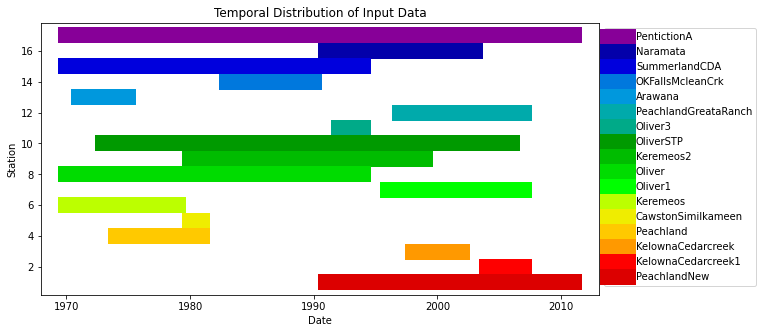

In [8]:
fig,ax = plt.subplots(figsize=(10,5))
colors = cm.nipy_spectral(np.linspace(0.1, 0.9, stations.shape[0]))

for i,c in enumerate(colors):
  line, = ax.plot([int(stations_list[i]['Date/Time'].iloc[0].split('-')[0]),int(stations_list[i]['Date/Time'].iloc[-1].split('-')[0])], 
                  [len(stations_list)-i,len(stations_list)-i], color=c, linewidth=16)
  line.set_label(stations["file-name"].iloc[i])

ax.legend(bbox_to_anchor=(1, 1.))
plt.ylabel("Station")
plt.xlabel("Date")
plt.title("Temporal Distribution of Input Data")
plt.show()

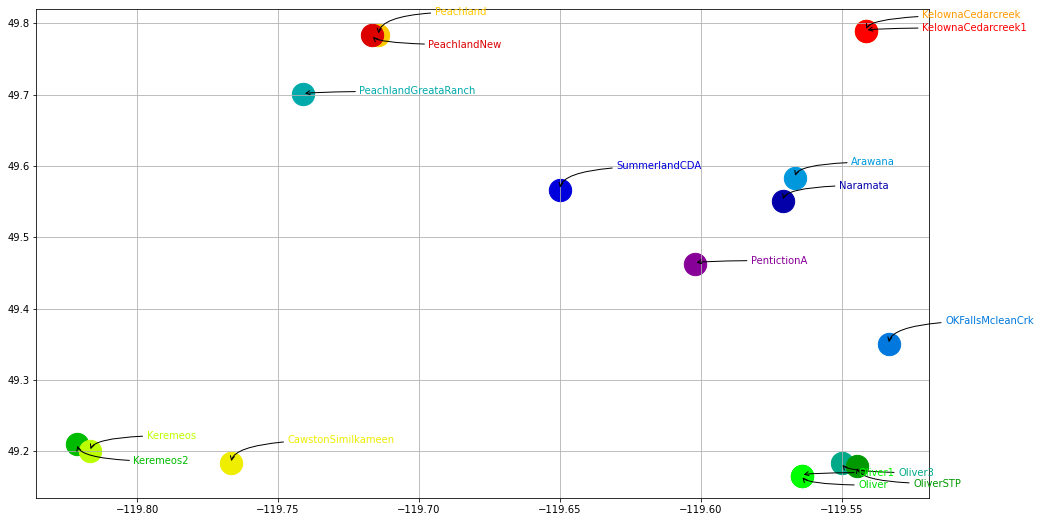

In [9]:
#Plot Station Locations
fig, ax = plt.subplots(figsize=(16,9))
plt.grid()
for i, c in enumerate(colors):
    ax.scatter(stations["longitudeX"].iloc[i], stations["latitudeY"].iloc[i], color=c, s=500)
    ax.annotate(stations["file-name"].iloc[i], (stations["longitudeX"].iloc[i], stations["latitudeY"].iloc[i]), xytext=(stations["longitudeX"].iloc[i]+0.02, stations["latitudeY"].iloc[i]+(0.03*math.sin(math.pi/5*i))), 
    arrowprops = dict(  arrowstyle="->",
                        connectionstyle="angle3,angleA=0,angleB=-90"),
                color=c)
plt.show()

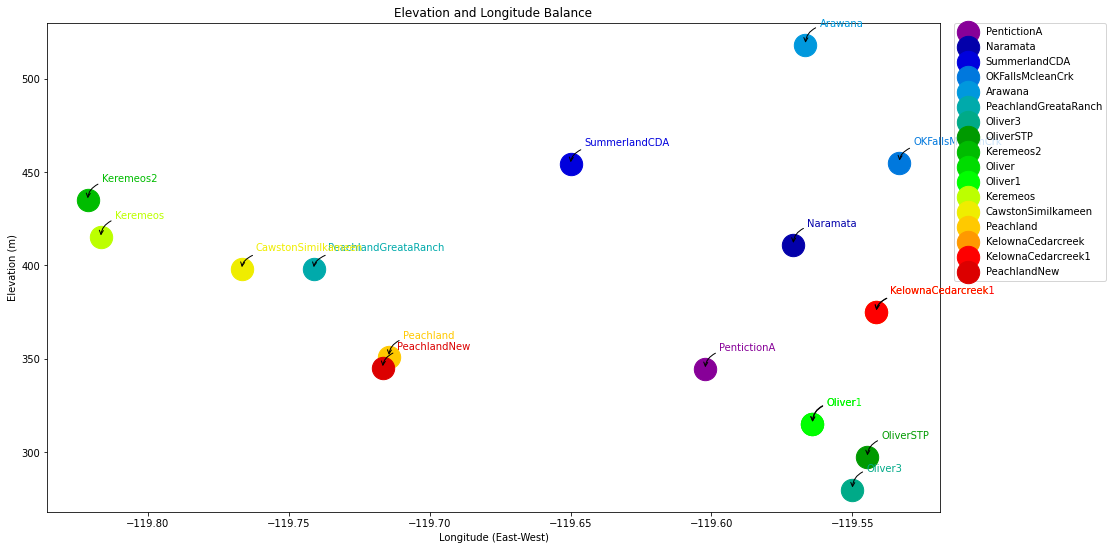

In [10]:
fig,ax = plt.subplots(figsize=(16,9))
for i,c in enumerate(colors):
  dot = ax.scatter(stations['longitudeX'].iloc[i], stations['elevation'].iloc[i], color=c, s=500)
  dot.set_label(stations["file-name"].iloc[i])
  ax.annotate(stations["file-name"].iloc[i], (stations["longitudeX"].iloc[i], stations["elevation"].iloc[i]), xytext=(stations["longitudeX"].iloc[i]+0.005, stations["elevation"].iloc[i]+10), 
    arrowprops = dict(  arrowstyle="->",
                        connectionstyle="angle3,angleA=0,angleB=-90"),
                color=c)
ax.legend(bbox_to_anchor=(1.01, 1.01))
plt.ylabel("Elevation (m)")
plt.xlabel("Longitude (East-West)")
plt.title("Elevation and Longitude Balance")
plt.show()

# **Training and Validation Set**

In [11]:
from tsai.all import *
my_setup()

os              : Linux-5.10.133+-x86_64-with-glibc2.27
python          : 3.8.16
tsai            : 0.3.4
fastai          : 2.7.10
fastcore        : 1.5.27
torch           : 1.13.0+cu116
device          : 1 gpu (['Tesla T4'])
cpu cores       : 1
threads per cpu : 2
RAM             : 12.68 GB
GPU memory      : [14.75] GB


## Data Formatting and Separation

In [12]:
#turning Date/Time into a Year Integer
copy = pd.DataFrame()
indexes = []
for data_frame in stations_list:
  data_frame.loc[:,"Date/Time"] = [int(data_frame.loc[i,"Date/Time"].split('-')[0]) for i in range(data_frame.shape[0])]
  indexes.append(data_frame.shape[0])
  copy = pd.concat([copy, data_frame])
stations_list[0].head()

Longitude (x)  Latitude (y)  Date/Time  Month  Day  Max Temp (°C)  \
0    -119.602222     49.463056       1970      1    1           -0.6   
1    -119.602222     49.463056       1970      1    2           -1.1   
2    -119.602222     49.463056       1970      1    3           -0.6   
3    -119.602222     49.463056       1970      1    4           -1.1   
4    -119.602222     49.463056       1970      1    5           -3.9   

   Min Temp (°C)  Mean Temp (°C)  Total Rain (mm)  Total Snow (cm)  \
0           -5.6            -3.1              0.0              0.0   
1           -6.7            -3.9              0.0              0.3   
2           -7.8            -4.2              0.0              4.1   
3          -11.7            -6.4              0.0              0.0   
4          -14.4            -9.2              0.0              0.0   

   Elevation (m)  
0          344.4  
1          344.4  
2          344.4  
3          344.4  
4          344.4

In [13]:
#Total inputs v.s. total NaN
total_variables = np.sum(np.array([stations_list[i].shape[0]*5 for i in range(len(stations_list))]))
total_nan_vars = len(np.argwhere(np.isnan(np.concatenate([stations.to_numpy() for stations in stations_list]))))
print(f"Total values: {total_variables}")
print(f"Total NaN values: {total_nan_vars}")
print(f"Missing Ratio: {total_nan_vars/total_variables}")


Total values: 452895
Total NaN values: 7855
Missing Ratio: 0.017343975976771658


In [14]:
from lovely_numpy import lo

Longitude (x)      -119.564167
Latitude (y)         49.165833
Date/Time          2001.498973
Month                 6.522930
Day                  15.729637
Max Temp (°C)        16.267241
Min Temp (°C)         5.048994
Mean Temp (°C)       10.711257
Total Rain (mm)       0.798676
Total Snow (cm)       0.098973
Elevation (m)       315.200000
dtype: float64


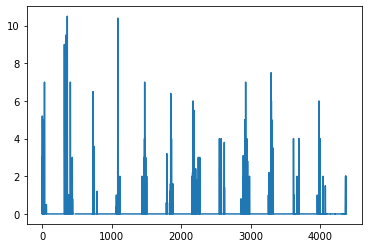

In [15]:
# cell for checking soundness of data
station=10
print(stations_list[station].mean())
plt.plot(stations_list[station]["Total Snow (cm)"])

In [16]:
# getting input data into the right format
training_set = []
testing_set = []
for i in range(len(stations_list)):
      i_years = np.unique(stations_list[i]["Date/Time"].to_numpy())
      
      training_set_temp = []
      testing_set_temp = []
      for year in i_years:
        if year in i_years and year<2004:
          i_indexes = np.where(stations_list[i]["Date/Time"].to_numpy()==year)
          training_set_temp.append(stations_list[i].to_numpy()[i_indexes])
        elif year in i_years and year>=2004:
          i_indexes = np.where(stations_list[i]["Date/Time"].to_numpy()==year)
          testing_set_temp.append(stations_list[i].to_numpy()[i_indexes])
      if not training_set_temp == []:
        training_set.append(np.concatenate(training_set_temp))
      if not testing_set_temp == []:
        testing_set.append(np.concatenate(testing_set_temp))

In [17]:
print(lo(training_set[12]))

array[731, 11] n=8041 x∈[-119.767, 1.981e+03] μ=221.122 σ=579.056 NaN!


In [18]:
print(lo(testing_set[4]))

array[1461, 11] n=16071 x∈[-119.541, 2.007e+03] μ=219.934 σ=583.984 NaN!


In [19]:
window_length = 360
stride = 1
training_length_counter = 0
testing_length_counter = 0
training_x = None
training_y = None
testing_x = None
testing_y = None

for i in range(len(training_set)):
  training = SlidingWindow(window_length, stride=stride, get_x=[5,6,7,8,9], get_y=[10])(training_set[i]) #3,4 #,10
  if training_x is not None:  
    training_x = np.concatenate([training_x, training[0]])
    training_y = np.concatenate([training_y, training[1]])
  else:
    training_x = training[0]
    training_y = training[1]
  training_length_counter += training[0].shape[0]

for i in range(len(testing_set)):  
  testing = SlidingWindow(window_length, stride=stride, get_x=[5,6,7,8,9], get_y=[10])(testing_set[i]) #3,4
  if testing_x is not None:
    testing_x = np.concatenate([testing_x, testing[0]])
    testing_y = np.concatenate([testing_y, testing[1]])
  else:
    testing_x = testing[0]
    testing_y = testing[1]

  testing_length_counter += testing[0].shape[0]

print(training_length_counter)
print(lo(training_x))
print(testing_length_counter)
print(lo(testing_x))

73496
array[73496, 5, 360] n=132292800 x∈[-28.500, 61.000] μ=5.858 σ=9.085 NaN!
9163
array[9163, 5, 360] n=16493400 x∈[-22.000, 45.600] μ=6.225 σ=9.045 NaN!


In [20]:
lo(testing_y)

array[9163] x∈[297.200, 398.000] μ=347.385 σ=27.024

In [21]:
lo(training_y)

array[73496] x∈[280.000, 518.200] μ=371.080 σ=60.370

In [22]:
# Normalizing the labels using robust scaling
from sklearn.preprocessing import QuantileTransformer

training_y = training_y.reshape(-1,1)
testing_y = testing_y.reshape(-1,1)
qt = QuantileTransformer(n_quantiles=25, random_state=42)
training_y = qt.fit_transform(training_y)
trans_testing_y = qt.transform(testing_y)

In [23]:
lo(trans_testing_y)

array[9163, 1] x∈[0.083, 0.625] μ=0.430 σ=0.154

In [24]:
lo(training_y)

array[73496, 1] x∈[0., 1.000] μ=0.497 σ=0.286

(array([11698.,     0., 11333., 12058.,     0.,  8416.,  6955., 10237.,
         8771.,  4028.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

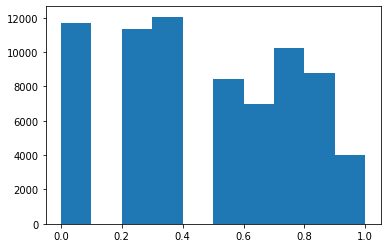

In [25]:
plt.hist(training_y)

(array([ 736.,    0., 1101.,    0.,    0., 2562.,    0., 2562.,    0.,
        2202.]),
 array([0.08333333, 0.1375    , 0.19166667, 0.24583333, 0.3       ,
        0.35416667, 0.40833333, 0.4625    , 0.51666667, 0.57083333,
        0.625     ]),
 <a list of 10 Patch objects>)

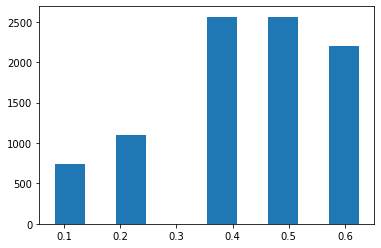

In [26]:
plt.hist(trans_testing_y)

## Creation of DataLoaders

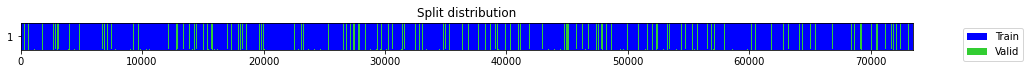

((#62472) [63322,2391,59740,44092,36660,24627,23391,10219,11045,63299...],
 (#11024) [61253,6243,56303,45052,14497,72367,29613,5131,68780,13889...])

In [27]:
#Base-Split
base_splits = get_splits(training_y, valid_size=.15, stratify=True, random_state=42, shuffle=True) #valid_size=.08422
base_splits

X      - shape: [73496 samples x 5 features x 360 timesteps]  type: ndarray  dtype:float64  isnan: 1927752
y      - shape: (73496, 1)  type: ndarray  dtype:float64  isnan: 0
splits - n_splits: 2 shape: [62472, 11024]  overlap: False


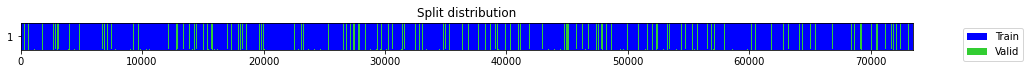

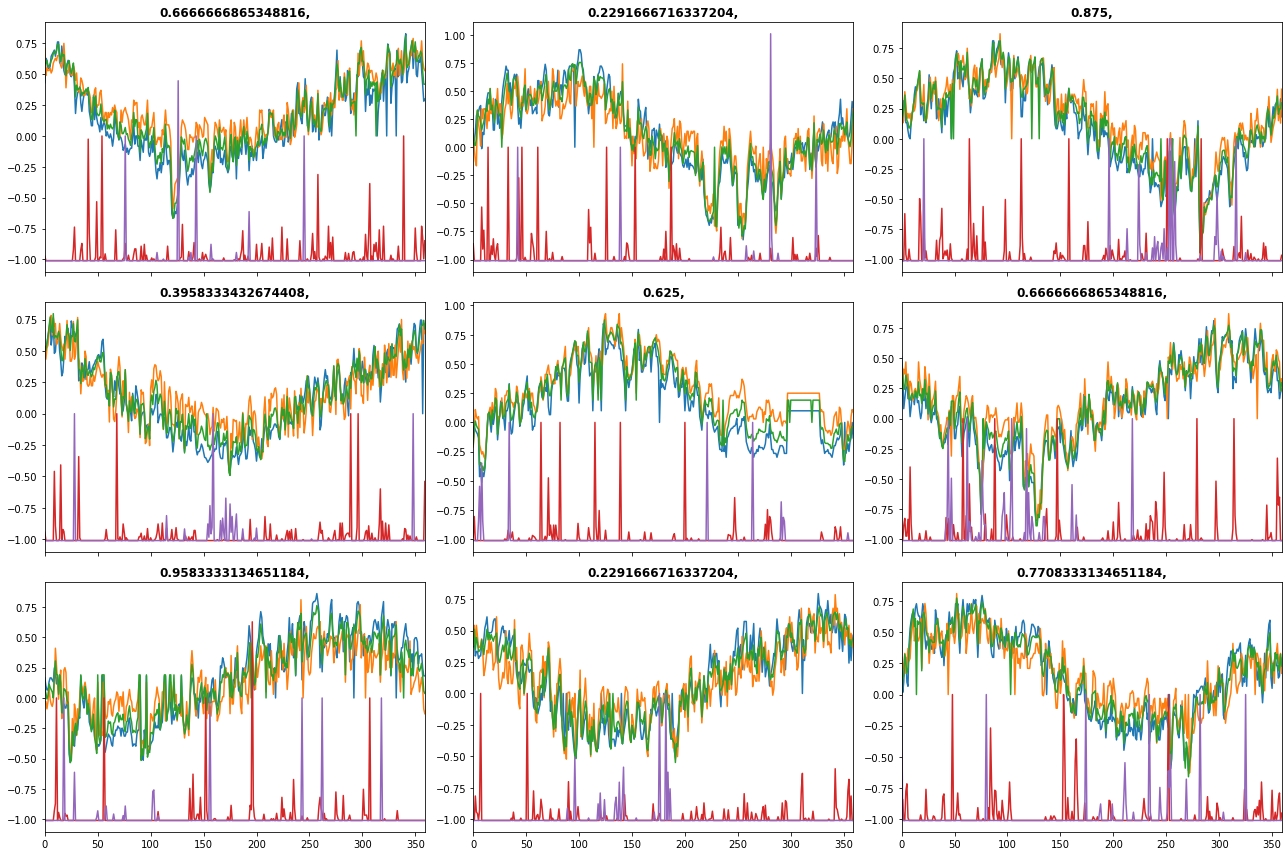

In [28]:
#Base-DataLoader with full labeled Dataset
tfms  = [None, [TSRegression()]]
pre_train_tfms = [TSNan2Value(median=True), TSNormalize(by_sample=False, by_var=True)]
train_tfms = [TSNan2Value(median=True), TSNormalize(by_sample=False, by_var=True),TSInputDropout(.01)] #
full_dloader = get_ts_dls(X=training_x, y=training_y, tfms=tfms, batch_tfms=train_tfms, splits=base_splits, bs=128)
check_data(training_x, training_y, base_splits)
full_dloader.show_batch()

X      - shape: [73496 samples x 5 features x 360 timesteps]  type: ndarray  dtype:float64  isnan: 1927752
y      - shape: (73496, 1)  type: ndarray  dtype:float64  isnan: 0
splits - n_splits: 2 shape: [1874, 11024]  overlap: [24118, 10864, 42070, 21565, 35233, 4891, 14401, 38078, 19183, 9203, 55000, 45539, 20616, 61979, 59627, 48189, 28655, 12398, 5449, 60211, 42186, 25496, 56141, 38255, 45883, 47617, 17309, 53439, 51730, 27940, 38103, 48532, 48004, 42491, 33566, 5156, 17372, 35049, 55708, 47686, 28326, 14793, 42270, 45975, 26246, 8520, 5196, 23191, 6106, 50845, 15722, 9578, 11331, 20115, 30763, 10605, 51535, 37245, 1867, 42059, 36462, 9463, 38787, 51492, 25816, 45862, 44335, 53802, 50614, 35810, 25714, 41071, 55092, 16679, 2673, 55290, 27983, 33297, 19194, 28488, 7152, 51049, 3147, 27929, 24396, 46962, 59465, 32551, 5088, 26133, 12448, 29786, 40959, 49426, 44440, 34562, 51463, 17620, 43055, 41356, 36668, 42956, 3251, 19695, 54738, 47563, 10653, 34553, 15864, 7056, 48188, 46428, 35604

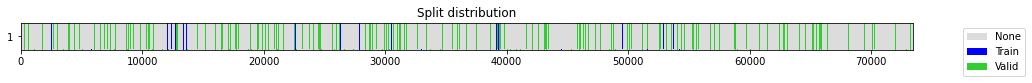

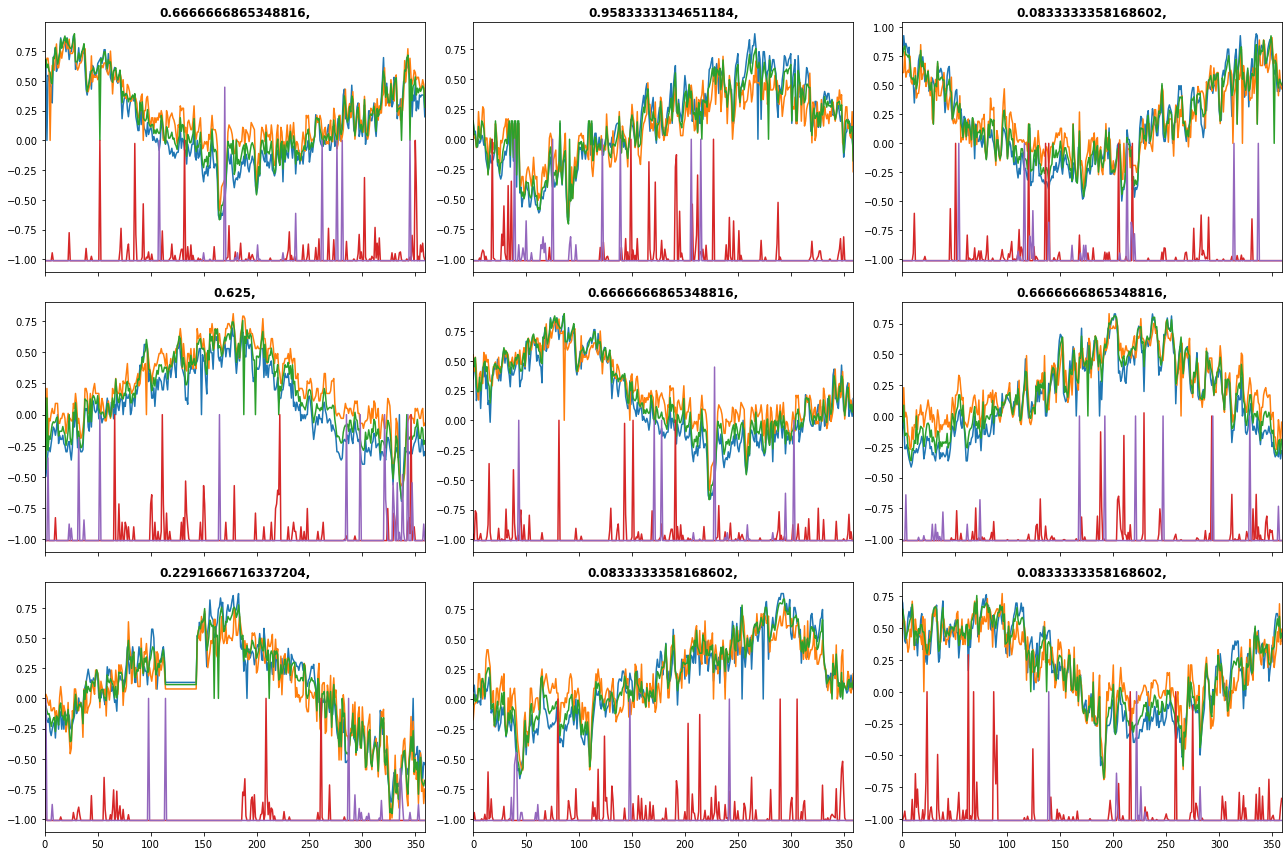

In [29]:
# Creating the small Data-loaders for the data-sparse case
small_train_split = get_splits(training_y[base_splits[0]], valid_size=.03, stratify=False, random_state=21, shuffle=True, show_plot=False)[1]
small_splits = (small_train_split, base_splits[1])
check_data(training_x, training_y, small_splits)
small_data_loader = get_ts_dls(training_x, training_y, splits=small_splits, tfms=tfms, batch_tfms=train_tfms, bs=128)
small_data_loader.show_batch()

X      - shape: [73496 samples x 5 features x 360 timesteps]  type: ndarray  dtype:float64  isnan: 1927752
y      - shape: (73496, 1)  type: ndarray  dtype:float64  isnan: 0
splits - n_splits: 2 shape: [62472, 11024]  overlap: False


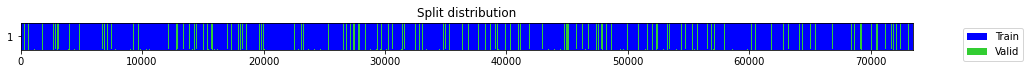

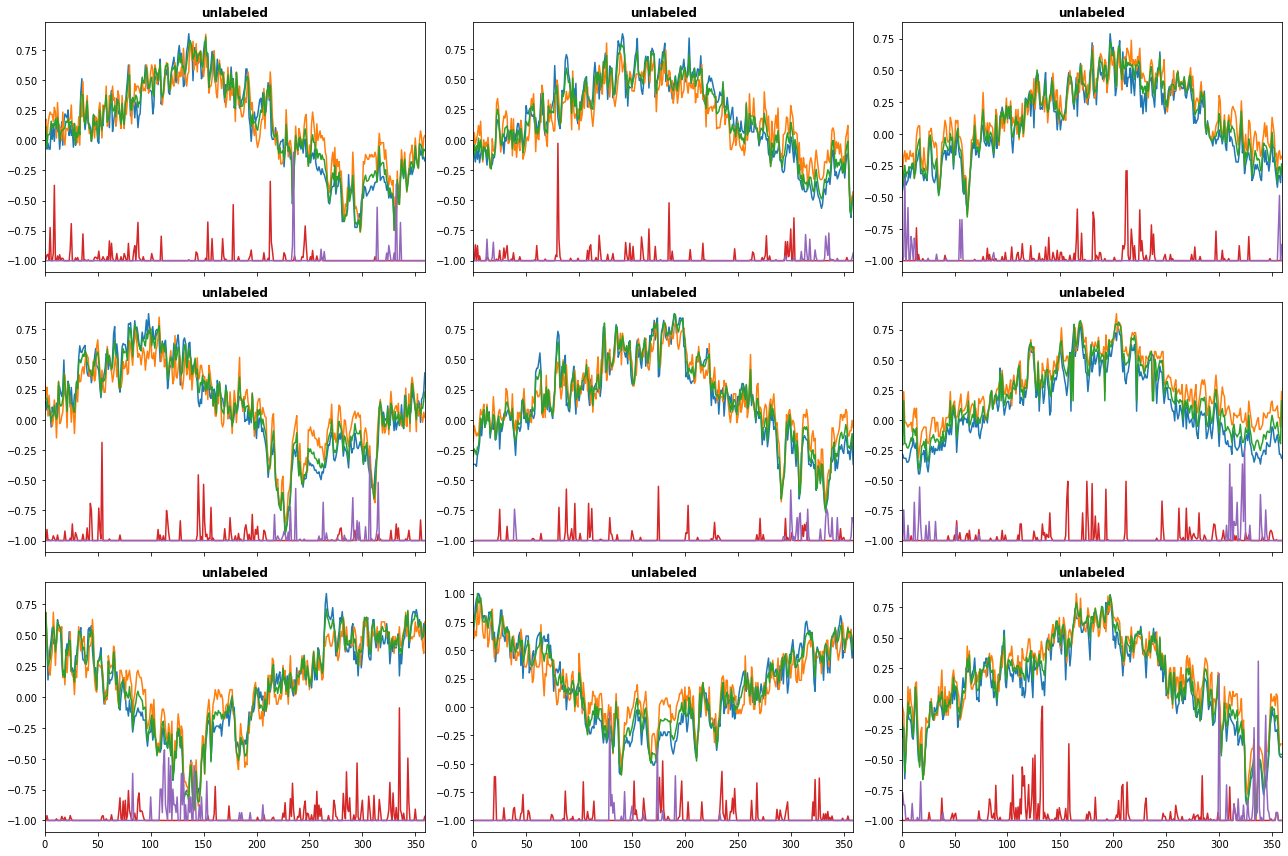

In [30]:
# Unlabeled Full Data-set
unlabeled_dloader = get_ts_dls(X=training_x, batch_tfms=pre_train_tfms, splits=base_splits, bs=128)
check_data(training_x, training_y, base_splits)
unlabeled_dloader.show_batch()

valid == train
X      - shape: [9163 samples x 5 features x 360 timesteps]  type: ndarray  dtype:float64  isnan: 255114
y      - shape: (9163, 1)  type: ndarray  dtype:float64  isnan: 0
splits - n_splits: 2 shape: [9163, 9163]  overlap: [8751, 7782, 153, 3977, 8326, 5586, 6282, 831, 3888, 3402, 941, 4641, 1811, 2617, 4418, 4687, 1140, 3172, 6270, 4469, 6102, 4613, 3716, 5914, 38, 7298, 7323, 1020, 8570, 2878, 4285, 2263, 490, 682, 7731, 8127, 8374, 7935, 1170, 6577, 8076, 45, 8734, 6442, 4708, 3928, 9159, 2737, 1356, 2154, 3018, 224, 1325, 1252, 6455, 2138, 5648, 9117, 3381, 5103, 1273, 1957, 1728, 1223, 640, 950, 3680, 6347, 1699, 428, 5499, 7288, 2264, 8756, 4916, 8012, 4585, 1346, 6581, 8370, 6696, 3986, 7599, 8026, 494, 8937, 4224, 6207, 93, 2104, 1065, 5646, 9138, 3862, 7742, 4488, 3733, 8132, 4064, 7095, 3689, 8068, 4802, 5838, 3187, 5256, 6931, 2510, 8228, 6709, 8778, 1373, 2911, 4234, 2124, 2070, 68, 6170, 2584, 4483, 473, 4481, 5234, 4729, 5126, 2626, 2567, 5247, 7522, 7082, 4

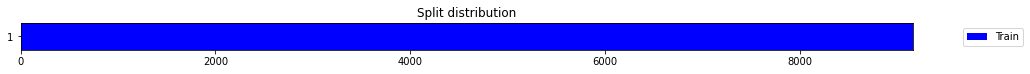

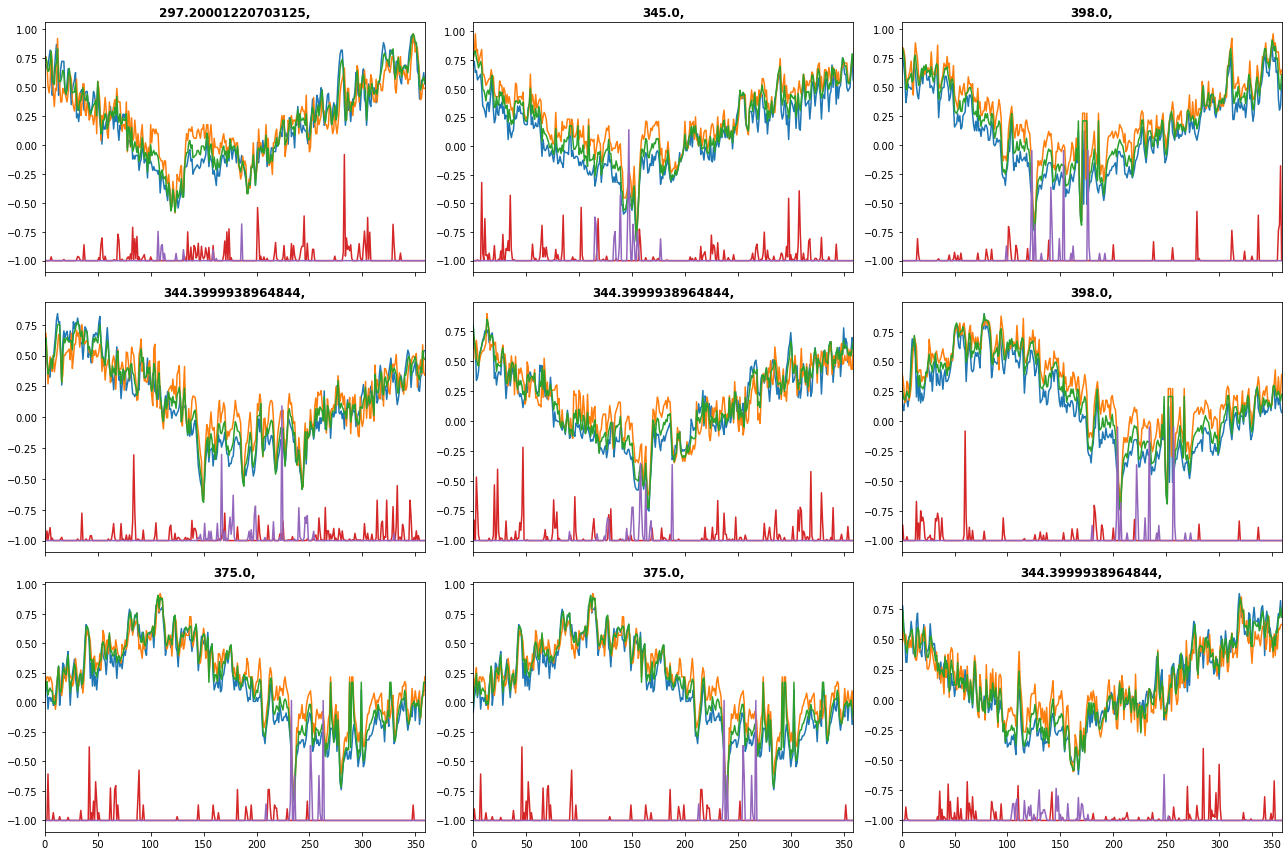

In [31]:
# Test-Data Loader
test_splits = get_splits(testing_y, valid_size=0, stratify=True, random_state=42, shuffle=False, show_plot=False)
test_dloader = get_ts_dls(X=testing_x, y=testing_y, tfms=tfms, batch_tfms=pre_train_tfms, splits=test_splits, bs=128)
check_data(testing_x, testing_y, test_splits)
test_dloader.show_batch()

# **Model Creation**

## Baseline Model

SuggestedLRs(valley=2.0892961401841603e-05)

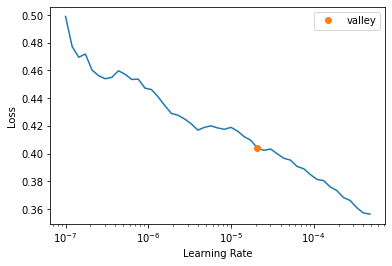

In [42]:
base_learner = ts_learner(small_data_loader, InceptionTimePlus, metrics=[mse], cbs=[ShowGraph(), PredictionDynamics()])
base_learner.lr_find()

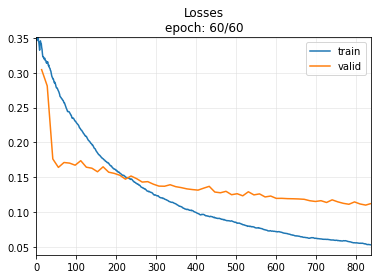

train_loss  valid_loss       mse
59    0.052698    0.112272  0.112272

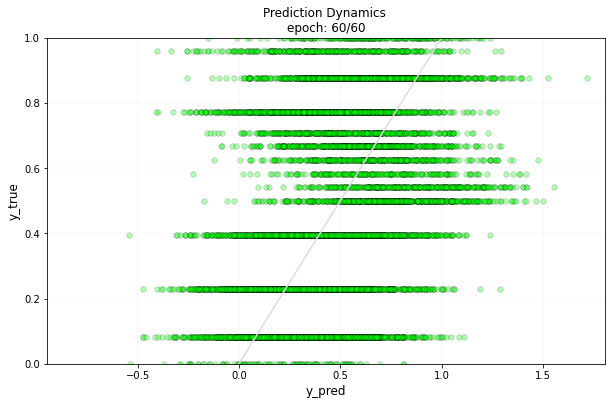

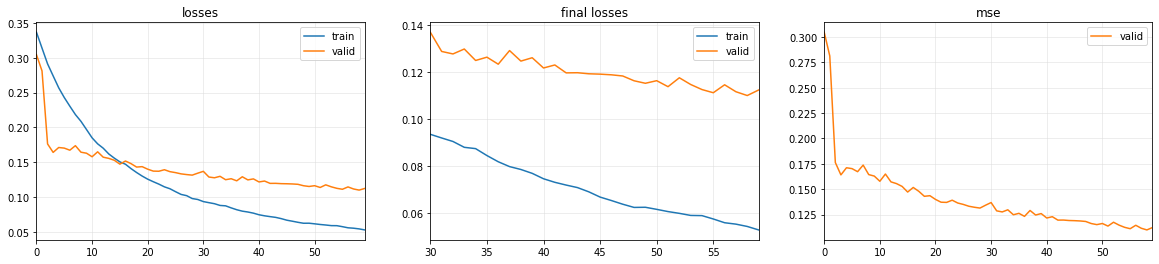

In [43]:
base_learner.fit(60, lr= 1e-5)

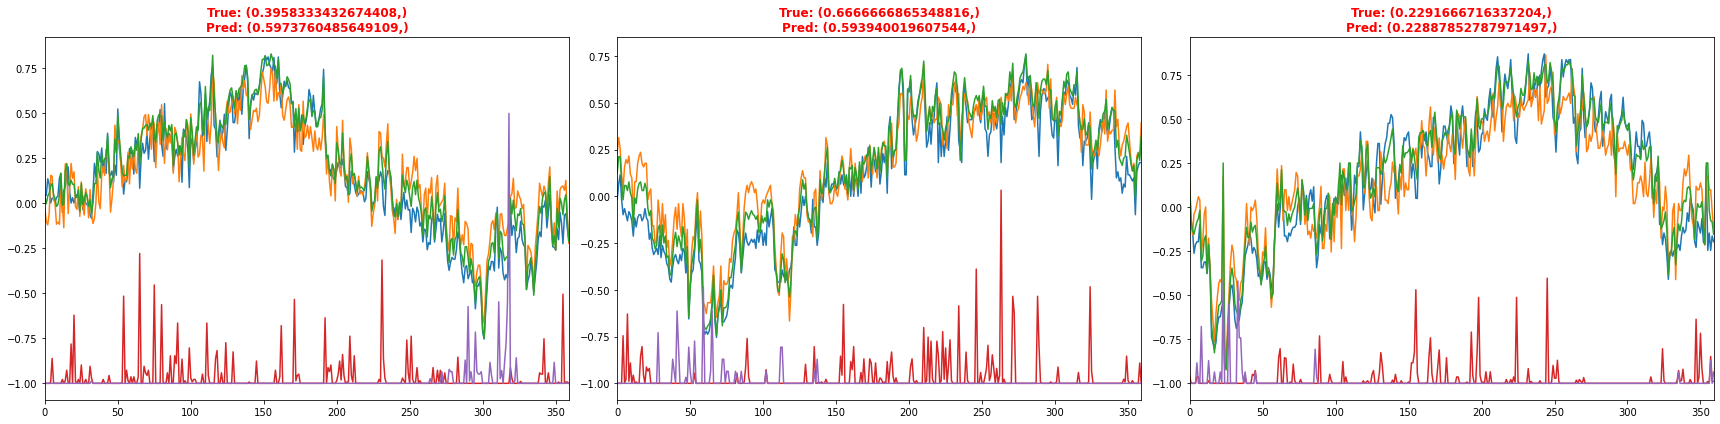

In [44]:
base_learner.show_results(max_n=3, figsize=(24,6))

## Model with Pre-Training

### Pre-Training

SuggestedLRs(valley=0.0014454397605732083)

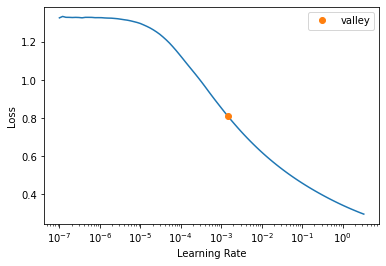

In [45]:
pre_training_learner = ts_learner(unlabeled_dloader, InceptionTimePlus, metrics=[mse], cbs=[ShowGraph(), MVP(target_dir=os.path.join(data_path, '/model/MVP'), fname=f'pre_trained_TSBERT')])
pre_training_learner.lr_find()

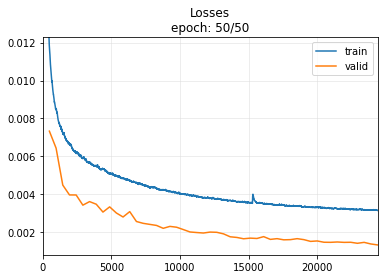

best epoch:  49  val_loss: 0.001325 - pretrained weights_path='/model/MVP/pre_trained_TSBERT.pth'


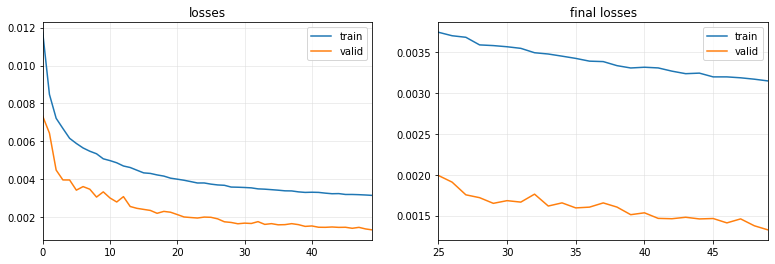

In [46]:
pre_training_learner.fit(50, lr=1e-3)

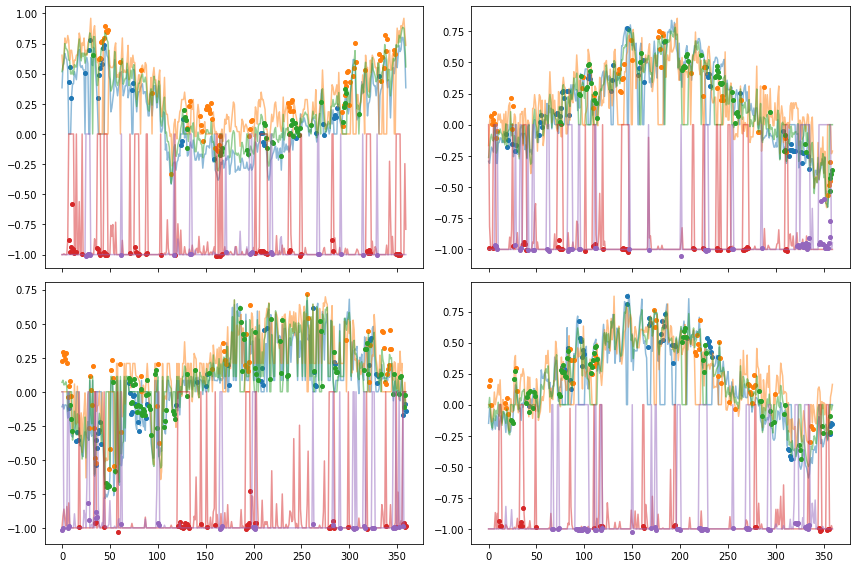

In [47]:
pre_training_learner.MVP.show_preds(max_n=4, nrows=2, ncols=2)

### Fine-Tuning


weights from /model/MVP/pre_trained_TSBERT.pth successfully transferred!



SuggestedLRs(valley=6.30957365501672e-05)

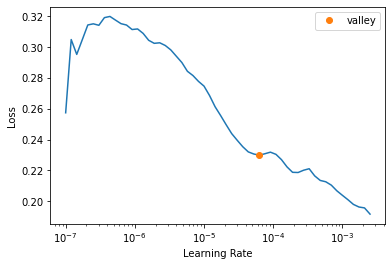

In [48]:
fine_tuning_learner = ts_learner(small_data_loader, InceptionTimePlus, pretrained=True, weights_path=os.path.join(data_path, '/model/MVP/pre_trained_TSBERT.pth'), metrics=[mse], cbs=[ShowGraph(), PredictionDynamics()])

fine_tuning_learner.lr_find()

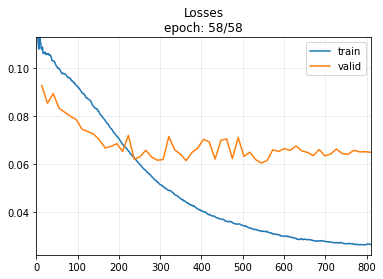

train_loss  valid_loss       mse
57    0.026532    0.064931  0.064931

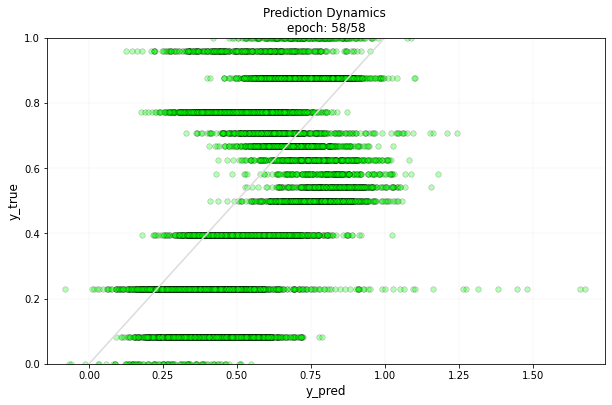

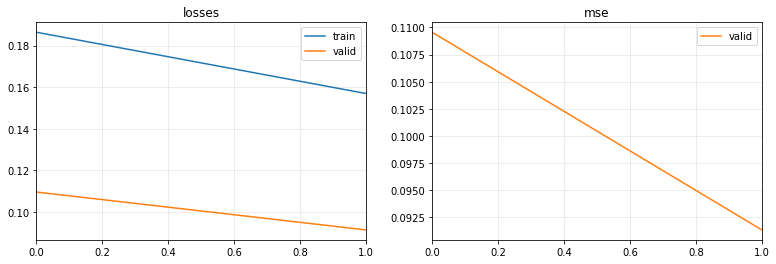

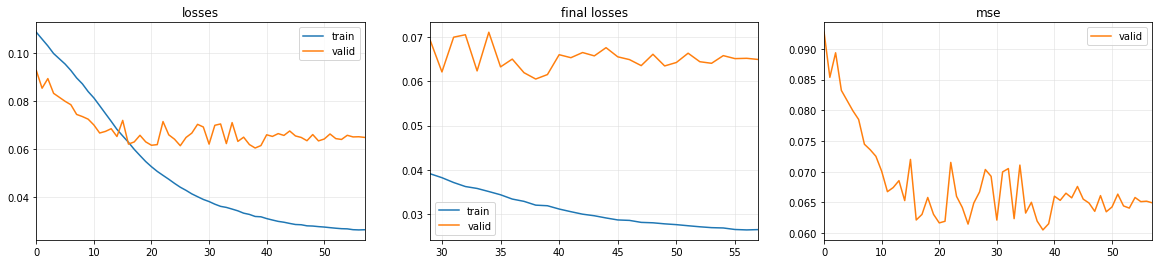

In [49]:
fine_tuning_learner.fine_tune(58, base_lr=1e-4, freeze_epochs=2)

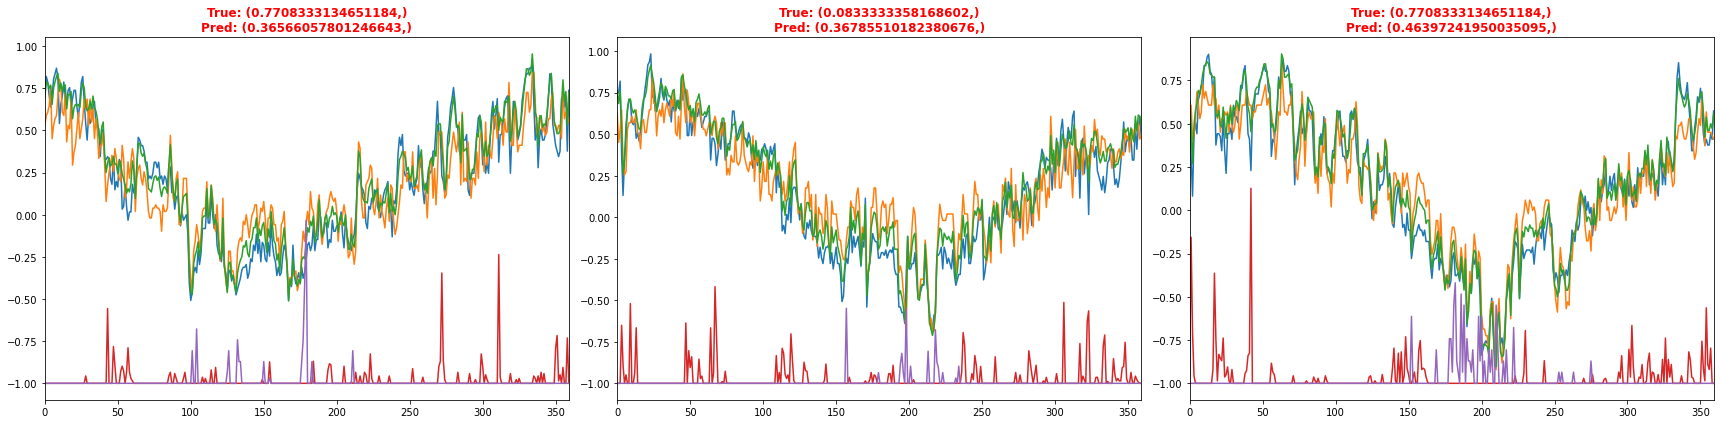

In [50]:
fine_tuning_learner.show_results(max_n=3, figsize=(24,6))

## Best-Case Model (All data, no-pretraining) 

SuggestedLRs(valley=1.4454397387453355e-05)

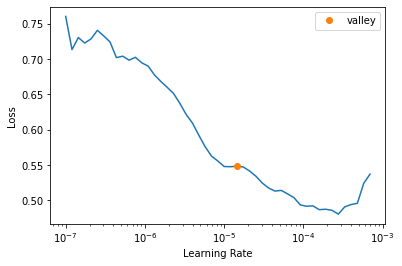

In [53]:
best_learner = ts_learner(full_dloader, InceptionTimePlus, metrics=[mse], cbs=[ShowGraph(), PredictionDynamics()])
best_learner.lr_find()

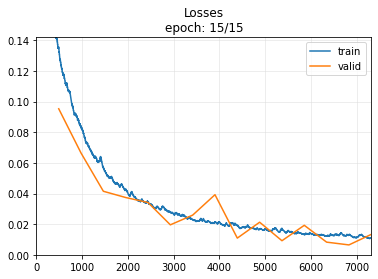

train_loss  valid_loss       mse
14    0.011048    0.013303  0.013303

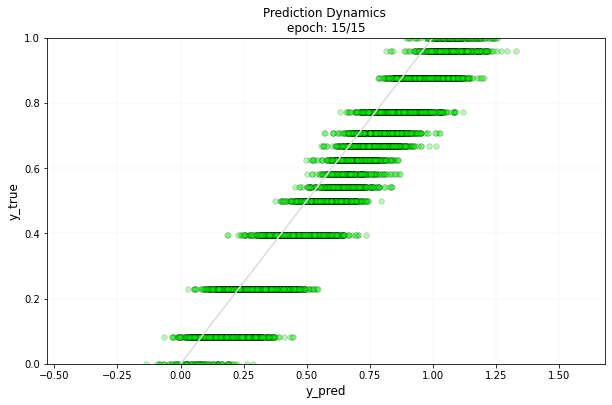

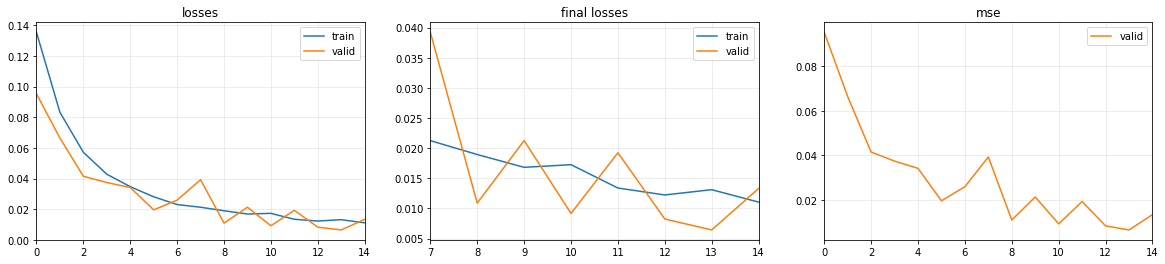

In [54]:
best_learner.fit(15, lr= 1e-5)

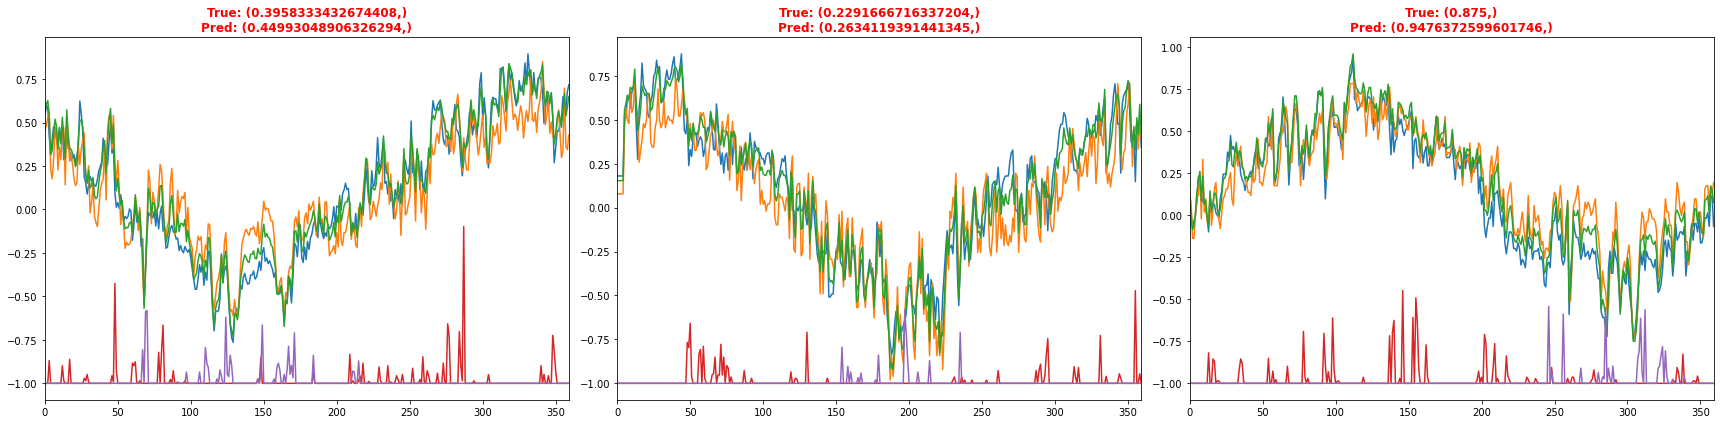

In [55]:
best_learner.show_results(max_n=3, figsize=(24,6))

## Exporting Models

In [57]:
base_learner.export("/content/gdrive/MyDrive/WeatherData/baseline.pkl")
fine_tuning_learner.export('/content/gdrive/MyDrive/WeatherData/transfer_learner.pkl')
best_learner.export('/content/gdrive/MyDrive/WeatherData/best_baseline.pkl')

# **Load Models and Predict**

In [34]:
import sklearn.metrics as skm
# Load Baseline Model
base_learner = load_learner("/content/gdrive/MyDrive/WeatherData/baseline.pkl", cpu=False)

__, _, val_preds = base_learner.get_X_preds(training_x[base_splits[1]])
__, _, training_preds = base_learner.get_X_preds(training_x[base_splits[0]])
__, _, preds = base_learner.get_X_preds(testing_x[test_splits[0]])

preds = qt.inverse_transform(preds)
val_preds = qt.inverse_transform(val_preds)
training_preds = qt.inverse_transform(training_preds)
og_training_y = qt.inverse_transform(training_y)

baseline_df = pd.DataFrame(preds)
baseline_df.to_csv(os.path.join(data_path, 'baseline_preds.csv'))
test_error = skm.mean_absolute_error(testing_y[test_splits[0]], preds)
val_error = skm.mean_absolute_error(og_training_y[base_splits[1]], val_preds)
training_error = skm.mean_absolute_error(og_training_y[base_splits[0]], training_preds)
print("Baseline Model:")
print(f"Training Error: {training_error.round(5)}\n")
print(f"Validation Error: {val_error.round(5)}\n") 
print(f"Test Error: {test_error.round(5)}\n")

Baseline Model:
Training Error: 55.46486

Validation Error: 55.56901

Test Error: 54.23104



In [35]:
fine_tuning_learner = load_learner('/content/gdrive/MyDrive/WeatherData/transfer_learner.pkl', cpu=False)

__, _, preds = fine_tuning_learner.get_X_preds(testing_x[test_splits[0]])
__, _, val_preds = fine_tuning_learner.get_X_preds(training_x[base_splits[1]])
__, _, training_preds = fine_tuning_learner.get_X_preds(training_x[base_splits[0]])

preds = qt.inverse_transform(preds)
val_preds = qt.inverse_transform(val_preds)
training_preds = qt.inverse_transform(training_preds)
og_training_y = qt.inverse_transform(training_y)

fine_df = pd.DataFrame(preds)
fine_df.to_csv(os.path.join(data_path, 'fine_tuned_preds.csv'))
test_error = skm.mean_absolute_error(testing_y[test_splits[0]], preds)
val_error = skm.mean_absolute_error(og_training_y[base_splits[1]], val_preds)
training_error = skm.mean_absolute_error(og_training_y[base_splits[0]], training_preds)
print("Fine Tuned Model:")
print(f"Training Error: {training_error.round(5)}\n")
print(f"Validation Error: {val_error.round(5)}\n") 
print(f"Test Error: {test_error.round(5)}\n")

Fine Tuned Model:
Training Error: 44.81546

Validation Error: 44.73339

Test Error: 50.38919



In [36]:
best_learner = load_learner('/content/gdrive/MyDrive/WeatherData/best_baseline.pkl', cpu=False)
__, _, preds = best_learner.get_X_preds(testing_x[test_splits[0]])
__, _, val_preds = best_learner.get_X_preds(training_x[base_splits[1]])
__, _, training_preds = best_learner.get_X_preds(training_x[base_splits[0]])

preds = qt.inverse_transform(preds)
val_preds = qt.inverse_transform(val_preds)
training_preds = qt.inverse_transform(training_preds)
og_training_y = qt.inverse_transform(training_y)

best_df = pd.DataFrame(preds)
best_df.to_csv(os.path.join(data_path, 'best_preds.csv'))
test_error = skm.mean_absolute_error(testing_y[test_splits[0]], preds)
val_error = skm.mean_absolute_error(og_training_y[base_splits[1]], val_preds)
training_error = skm.mean_absolute_error(og_training_y[base_splits[0]], training_preds)
print("Best Model")
print(f"Training Error: {training_error.round(5)}\n")
print(f"Validation Error: {val_error.round(5)}\n") 
print(f"Test Error: {test_error.round(5)}\n")

Best Model
Training Error: 19.71655

Validation Error: 20.11043

Test Error: 26.54385

